In [1]:

#~ importing libraries

import pandas as pd, numpy as np, requests, os, matplotlib.pyplot as plt, seaborn as sns

from meteostat import Hourly, Point
from datetime import datetime

from pathlib import Path



In [2]:
#~ setting up project directories 

PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_DIR = PROJECT_ROOT / 'data' 

RAW_DIR = DATA_DIR / 'raw'

PROCESSED_DIR = DATA_DIR / 'processed'

MODEL_DIR = PROJECT_ROOT/ 'models'

# Generating Dataset

In [3]:

#~ fetching hourly weather data from meteostat for Montreal City from 2023-2024
montreal = Point(45.5017, -73.5673)

weather_df = Hourly(
    montreal,
    start=datetime(2025, 1, 1),
    end=datetime(2025, 12, 1)
).fetch()

In [4]:

bixi_trip_df = pd.read_csv(RAW_DIR/'BIXI_Trip_2025.csv')

In [5]:

weather_df.reset_index(inplace=True)

#~ Dropping columns where all values are missing + dropping other not relevant predictors columns

weather_df.drop(columns=['snow','wpgt','tsun', 'pres', 'coco','wdir', 'rhum'], inplace=True)

#~ renaming weather_df's columns to a more descriptive name

weather_df.rename(columns={'temp':'temperature',
                           'dwpt':'dew_point',
                           'prcp':'precipitation',
                           'wspd':'wind_speed'
                           }, inplace=True)

# Data Cleaning

In [6]:


#~ standardizing columnsNames of bixi_trip_df

bixi_trip_df.columns = (bixi_trip_df.columns              
              .str.normalize('NFKD')                    
              .str.encode('ascii','ignore').str.decode('ascii')
              .str.strip()
              .str.lower()
              .str.replace(r'[^a-z0-9]+', '_', regex=True)  
              .str.replace(r'_+', '_', regex=True)          
              .str.strip('_'))



bixi_trip_df.dropna(inplace=True)

bixi_trip_df['starttime'] = (
    pd.to_datetime(bixi_trip_df["starttimems"], unit='ms', utc=True)
      .dt.floor("s")                           #~ the data showed time zone in ISO-8601 format, I stopped at seconds
      .dt.tz_convert("America/Toronto")
      .dt.tz_localize(None)        
)


bixi_trip_df['endtime'] = (
    pd.to_datetime(bixi_trip_df["endtimems"], unit='ms', utc=True)
      .dt.floor("s")                           
      .dt.tz_convert("America/Toronto")
      .dt.tz_localize(None)       
)

bixi_trip_df.drop(columns=['starttimems', 'endtimems'],inplace=True) #~ dropping the initial unix time columns



#~ adding column to bring out the hour of the day, the day of week, day of month, and month of the year for starting time and endtime

#~Hour of day (0–23)

bixi_trip_df["start_hour"] = bixi_trip_df["starttime"].dt.hour
bixi_trip_df["end_hour"]   = bixi_trip_df["endtime"].dt.hour

#~Day of week (1–7, Monday=1, Sunday=7)

bixi_trip_df["start_day"] = bixi_trip_df["starttime"].dt.dayofweek + 1
bixi_trip_df["end_day"]   = bixi_trip_df["endtime"].dt.dayofweek + 1

#~Day of month (1–31)
bixi_trip_df["start_dayofmonth"] = bixi_trip_df["starttime"].dt.day
bixi_trip_df["end_dayofmonth"]   = bixi_trip_df["endtime"].dt.day

#~Month of year (1–12)

bixi_trip_df["start_month"] = bixi_trip_df["starttime"].dt.month
bixi_trip_df["end_month"]   = bixi_trip_df["endtime"].dt.month







# Feature Engineering

In [7]:


#~ getting the duration for each trip

bixi_trip_df['trip_duration'] = bixi_trip_df['endtime'] - bixi_trip_df['starttime']


#~ converting the trip_duration in minutes

td = pd.to_timedelta(bixi_trip_df['trip_duration'], errors='coerce')

#~ rounding the trip_duration to 2 decimal places

bixi_trip_df['trip_duration_min'] = (td.dt.total_seconds() / 60).round(2)

#~ dropping the trip_duration column
bixi_trip_df.drop(columns=['trip_duration'], inplace=True)


#~ filtering out trips with duration less than or equal to 0 minutes
bixi_trip_df = (bixi_trip_df[bixi_trip_df['trip_duration_min'] > 0].reset_index(drop=True))

#~ filtering out trips with duration greater than 120 minutes (2 hours)
bixi_trip_df = bixi_trip_df[bixi_trip_df["trip_duration_min"] <= 120]


#~ floor BIXI trip starttime to the nearest hour to merge with weather data
bixi_trip_df['starttime_hourly'] = bixi_trip_df['starttime'].dt.floor('h')



#~ merging BIXI trip data with weather data

bixi_weather_df = bixi_trip_df.merge(
    weather_df,
    how="left",
    left_on="starttime_hourly",
    right_on="time"
)



#~ aggregating data to create the modeling dataframe with total demand per station per hour

forecasting_df = (
    bixi_weather_df
    .groupby(["startstationname", "starttime_hourly"])
    .agg(
        total_demand=("trip_duration_min", "count"),
        arrondissement=("startstationarrondissement", "first"),
        temperature=("temperature", "mean"),
        precipitation=("precipitation", "mean"),
        wind_speed=("wind_speed", "mean"),
        latitude=("startstationlatitude", "first"),
        longitude=("startstationlongitude", "first")
        
    )
    .reset_index()
)

#~ removing rows with missing weather data 
forecasting_df = forecasting_df.dropna(subset=['temperature', 'precipitation', 'wind_speed']).reset_index(drop=True)


#~ sorting by station name and starttime_hourly
forecasting_df = forecasting_df.sort_values(by=['startstationname', 'starttime_hourly']).reset_index(drop=True)

#~ bringing out the hour 

forecasting_df['hour'] = forecasting_df['starttime_hourly'].dt.hour

#~ bringing out the day of week
forecasting_df['day_of_week'] = forecasting_df['starttime_hourly'].dt.dayofweek #~Monday=0, Sunday=6

#~ is weekend flag
forecasting_df['is_weekend'] = forecasting_df['day_of_week'].isin([5, 6]).astype(int)

#~month of year
forecasting_df['month'] = forecasting_df['starttime_hourly'].dt.month


#~ cyclical encoding for hour
forecasting_df['hour_sin'] = np.sin(2 * np.pi * forecasting_df['hour'] / 24)
forecasting_df['hour_cos'] = np.cos(2 * np.pi * forecasting_df['hour'] / 24)

#~ cyclical encoding for day of week
forecasting_df['day_of_week_sin'] = np.sin(2 * np.pi * forecasting_df['day_of_week'] / 7)
forecasting_df['day_of_week_cos'] = np.cos(2 * np.pi * forecasting_df['day_of_week'] / 7)

#~ weather feels like temperature
forecasting_df["feels_like_temp"] = forecasting_df["temperature"] - 0.7 * forecasting_df["wind_speed"]

#~ rain indicator
forecasting_df["is_raining"] = (forecasting_df["precipitation"] > 0).astype(int)

#~  creating lags per station for total demand

    #~ 1h lag
forecasting_df["lag_1h"] = forecasting_df.groupby("startstationname")["total_demand"].shift(1)
    #~ 24h lag
forecasting_df["lag_24h"] = forecasting_df.groupby("startstationname")["total_demand"].shift(24)

#~ creating rolling means per station for total demand

forecasting_df["rolling_3h"] = (
    forecasting_df.groupby("startstationname")["total_demand"]
    .shift(1)
    .groupby(forecasting_df["startstationname"])
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

forecasting_df["rolling_24h"] = (
    forecasting_df.groupby("startstationname")["total_demand"]
    .shift(1)
    .groupby(forecasting_df["startstationname"])
    .rolling(24)
    .mean()
    .reset_index(level=0, drop=True)
)

#~ keeping station name as category
forecasting_df["startstationname"] = forecasting_df["startstationname"].astype("category")

#~ keeping arrondissement as category
forecasting_df["arrondissement"] = forecasting_df["arrondissement"].astype("category")    

#~ dropping rows with missing lags (this is the warm up period)

forecasting_df = forecasting_df.dropna(
    subset=["lag_1h", "lag_24h", "rolling_3h", "rolling_24h"]
).reset_index(drop=True)



#~ parquet the final model dataframe

forecasting_df.to_parquet(PROCESSED_DIR/'forecasting_df.parquet', index=False)

# Backtesting with Trained Model

In [8]:

forecasting_df = pd.read_parquet(PROCESSED_DIR/'forecasting_df.parquet')

forecasting_df.shape, forecasting_df.columns

((2851337, 23),
 Index(['startstationname', 'starttime_hourly', 'total_demand',
        'arrondissement', 'temperature', 'precipitation', 'wind_speed',
        'latitude', 'longitude', 'hour', 'day_of_week', 'is_weekend', 'month',
        'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
        'feels_like_temp', 'is_raining', 'lag_1h', 'lag_24h', 'rolling_3h',
        'rolling_24h'],
       dtype='object'))

In [9]:

#~ setting up features

target = 'total_demand'

columns_to_drop = ["startstationname", "starttime_hourly", target, "arrondissement"]

X_2025 = forecasting_df.drop(columns=columns_to_drop)
y_2025 = forecasting_df[target]

## Load trained model and predict

In [10]:

import joblib

model = joblib.load(MODEL_DIR/'hgb_BIXI_DemandForecast_model_v1.pkl')


forecasting_df['y_pred'] = model.predict(X_2025)

## Evaluation

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_2025, forecasting_df["y_pred"])
rmse = np.sqrt(mean_squared_error(y_2025, forecasting_df["y_pred"]))
r2 = r2_score(y_2025, forecasting_df["y_pred"])

print(f"2025 Backtest → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")


2025 Backtest → MAE: 1.97 | RMSE: 3.12 | R²: 0.646


### Locking the result

In [12]:


out = forecasting_df[["startstationname", "starttime_hourly", "total_demand", "y_pred"]].copy()
out["error"] = out["y_pred"] - out["total_demand"]

out.to_parquet(PROCESSED_DIR/'forecast_2025.parquet', index=False)


One-Week Time Series for a station (Actual vs Predicted)

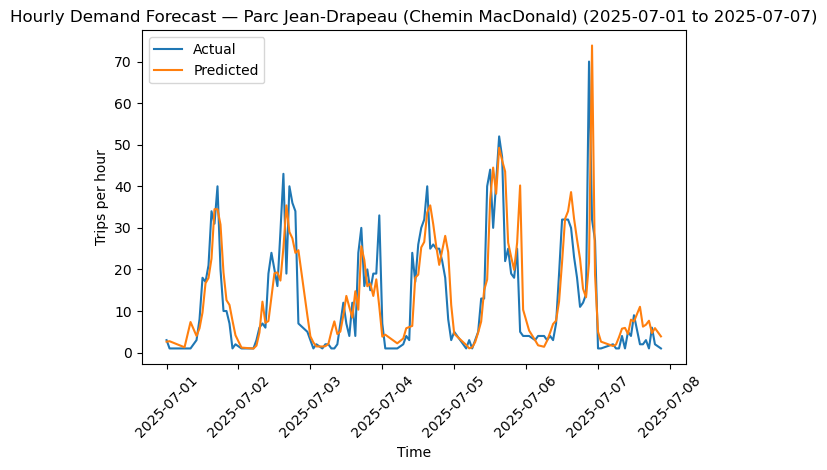

In [17]:

#~ loading the results
df = pd.read_parquet(PROCESSED_DIR/'forecast_2025.parquet')  # has actual + pred + error
df["starttime_hourly"] = pd.to_datetime(df["starttime_hourly"])

#~ choosing a station
station = 'Parc Jean-Drapeau (Chemin MacDonald)'

#~ picking a week
week_start = pd.Timestamp("2025-07-01")  
week_end = week_start + pd.Timedelta(days=7)

one = df[(df["startstationname"] == station) &
         (df["starttime_hourly"] >= week_start) &
         (df["starttime_hourly"] < week_end)].sort_values("starttime_hourly")

plt.figure()
plt.plot(one["starttime_hourly"], one["total_demand"], label="Actual")
plt.plot(one["starttime_hourly"], one["y_pred"], label="Predicted")
plt.title(f"Hourly Demand Forecast — {station} ({week_start.date()} to {(week_end - pd.Timedelta(days=1)).date()})")
plt.xlabel("Time")
plt.ylabel("Trips per hour")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



One week time series for total system demand

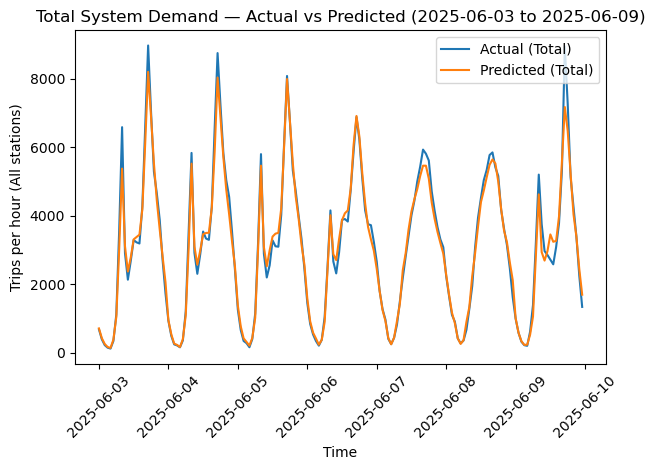

In [18]:


df2 = pd.read_parquet(PROCESSED_DIR/'forecast_2025.parquet') 
df2["starttime_hourly"] = pd.to_datetime(df2["starttime_hourly"])

week_start = pd.Timestamp("2025-06-03")  # change this
week_end = week_start + pd.Timedelta(days=7)

week = df2[(df2["starttime_hourly"] >= week_start) & (df2["starttime_hourly"] < week_end)]

ts = (week.groupby("starttime_hourly")[["total_demand", "y_pred"]]
          .sum()
          .reset_index()
          .sort_values("starttime_hourly"))

plt.figure()
plt.plot(ts["starttime_hourly"], ts["total_demand"], label="Actual (Total)")
plt.plot(ts["starttime_hourly"], ts["y_pred"], label="Predicted (Total)")
plt.title(f"Total System Demand — Actual vs Predicted ({week_start.date()} to {(week_end - pd.Timedelta(days=1)).date()})")
plt.xlabel("Time")
plt.ylabel("Trips per hour (All stations)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
